In [1]:
import time
import tensorflow as tf
import wandb
import pandas as pd
from prosit_t.wandb_agent.train_utils import get_proteometools_data
import seaborn as sns 
from dlomix.losses import masked_spectral_distance, masked_pearson_correlation_distance
import os
import matplotlib.pyplot as plt
from prosit_t.models import PrositTransformerV2,PrositCrossAtt
from dlomix.models import PrositIntensityPredictor

2023-09-14 15:40:23.693299: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 15:40:24.579704: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
wandb: ERROR Unable to patch Tensorflow/Keras
exception while trying to patch_tf_keras
Traceback (most recent call last):
  File "/cmnfs/home/l.mamisashvili/miniconda3/envs/prosit-t/lib/python3.9/site-packages/wandb/integration/keras/keras.py", line 86, in patch_tf_keras
    from keras.engine import training
ModuleNotFoundError: No module named 'keras.engine'
wandb: ERROR Unable to patch Tensorflow/Keras
exception while trying to patch_tf_keras
Traceback (most recent call last):
  File "/cmnfs/home/l.mamisashvili/miniconda3/envs/prosit-t/lib/python3.9/site-p

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# physical_devices = tf.config.list_physical_devices("GPU")
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
data_config = {
    "dataset": "proteometools",
    "data_source": {
        "train": "/cmnfs/proj/prosit/Transformer/first_pool_train.parquet",
        "val": "/cmnfs/proj/prosit/Transformer/first_pool_test.parquet",
    },
    "fragmentation": "HCD",
    "batch_size": 1024,
    "seq_length": 30,
}

In [4]:
project_name = "transforming-prosit-first-pool"
run = wandb.init(project=project_name)

wandb: Currently logged in as: mamisashvili-lizi (prosit-compms). Use `wandb login --relogin` to force relogin


In [5]:
_, val_data = get_proteometools_data(data_config)

2023-09-14 15:41:23.100800: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43640 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:21:00.0, compute capability: 8.6


In [6]:
def compute_losses(model, val_data, num_batches, batch_size):
    losses = []
    for sample in val_data.take(num_batches):
        x, y = sample
        predictions = model.predict(x, batch_size=batch_size)
        loss = masked_spectral_distance(y, predictions)
        losses.extend(loss.numpy())
    return losses

def plot_violin(losses, num_batches, color="skyblue"):
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    sns.violinplot(y=losses, color=color)
    plt.title(f"Distribution of Losses for {num_batches} Batches")
    plt.xlabel("Batches")
    plt.ylabel("Loss")
    plt.show() 

In [7]:
artifact_path = "prosit-compms/transforming-prosit-first-pool/model-driven-mountain-76:v130"

In [8]:
artifact = run.use_artifact(artifact_path)
model_dir = artifact.download()
loaded_model = tf.keras.models.load_model(model_dir, custom_objects={
    "masked_spectral_distance": masked_spectral_distance
})
weights = loaded_model.get_weights()

wandb:   5 of 5 files downloaded.  


In [9]:
in_sequence = tf.keras.layers.Input(shape=(30,))
in_collision_energy = tf.keras.layers.Input(shape=(1,))
in_precursor_charge = tf.keras.layers.Input(shape=(6,))

transformer = PrositCrossAtt(seq_length=30,embedding_output_dim=64,num_transformers=3,num_heads=16)
transformer.call(
            {
                "sequence": in_sequence,
                "collision_energy": in_collision_energy,
                "precursor_charge": in_precursor_charge,
            }
        )
transformer.set_weights(weights)

In [10]:
num_batches = 600
batch_size = 1024

In [11]:
transformer_loss = compute_losses(transformer, val_data, num_batches, batch_size)

2023-09-14 15:41:44.607686: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A40" frequency: 1740 num_cores: 84 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 45760577536 bandwidth: 696096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-14 15:41:45.244633: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 14ms/step


2023-09-14 15:41:46.396843: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8801


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 16ms/step


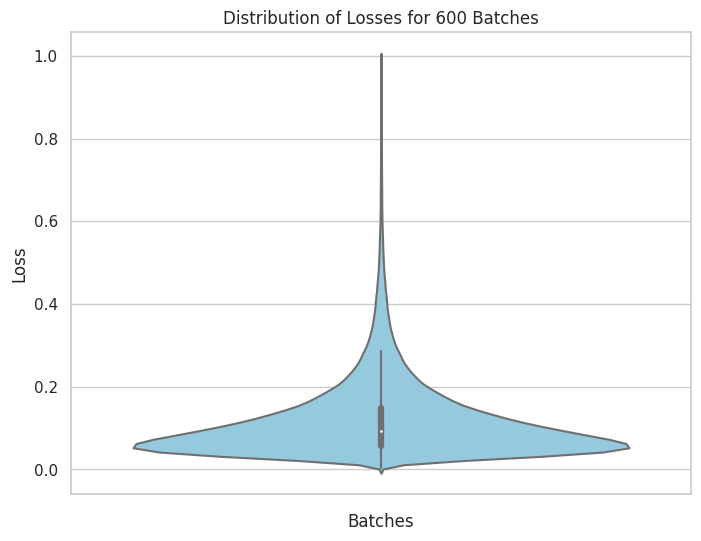

In [12]:
plot_violin(transformer_loss, num_batches, color="skyblue")

In [16]:
baseline_path = "prosit-compms/transforming-prosit-first-pool/model-classic-star-15:v45"
baseline_artifact = run.use_artifact(baseline_path)
baseline_dir = baseline_artifact.download()

wandb:   4 of 4 files downloaded.  


In [17]:
baseline = PrositIntensityPredictor(seq_length=30,embedding_output_dim=16,
        recurrent_layers_sizes=(256, 512))
baseline.load_weights(baseline_dir)

2023-09-14 15:50:39.582473: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ./artifacts/model-classic-star-15:v45: FAILED_PRECONDITION: artifacts/model-classic-star-15:v45; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [18]:
baseline_loss = compute_losses(baseline, val_data, num_batches, batch_size)

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 13ms/step
